In [1]:
from IPython.display import Image     # Import the Image function from IPython.display to display images in Jupyter environments.
from os import chdir                  # Import chdir from os module to change the current working directory.
from scipy.spatial import Delaunay  # Importar Delaunay
import numpy as np                    # Import numpy library for working with n-dimensional arrays and mathematical operations.
import gudhi as gd                    # Import gudhi library for computational topology and computational geometry.
import matplotlib.pyplot as plt       # Import pyplot from matplotlib for creating visualizations and graphs.
import argparse                       # Import argparse, a standard library for writing user-friendly command-line interfaces.
import seaborn as sns                 # Import seaborn for data visualization; it's based on matplotl.
import requests # Import requests library to make HTTP requests in Python easily.
import pandas as pd
from scipy.spatial.distance import pdist, squareform 
from sklearn.decomposition import PCA
from scipy.spatial import KDTree

In [2]:
#Me ayuda a ver que contiene cada archivo
import pandas as pd
import os

def mostrar_contenido_csv(ruta_directorio):
    archivos_csv = [archivo for archivo in os.listdir(ruta_directorio) if archivo.endswith('.csv')]
    for archivo_csv in archivos_csv:
        ruta_completa = os.path.join(ruta_directorio, archivo_csv)
        df = pd.read_csv(ruta_completa, header=None)
        print(f'Contenido de {archivo_csv}:')
        print(df)
        print("\n" + "="*50 + "\n")


In [3]:
mostrar_contenido_csv("/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv")


Contenido de -3_0_0.csv:
        0  1    2    3  4
0       2  B  119   82  0
1       4  B  120   82  0
2       4  B  121   82  0
3       4  B  122   82  0
4       4  B  123   82  0
...   ... ..  ...  ... ..
8524  161  A  139  182  0
8525  164  B  140  182  0
8526  164  B  141  182  0
8527  164  B  142  182  0
8528  164  B  143  182  0

[8529 rows x 5 columns]


Contenido de 9_0_0.csv:
        0  1    2    3  4
0      11  A  124   82  0
1       4  B  125   82  0
2       4  B  126   82  0
3       5  A  127   82  0
4       5  A  128   82  0
...   ... ..  ...  ... ..
8107  159  A  122  182  0
8108  159  A  123  182  0
8109  159  A  124  182  0
8110  159  A  125  182  0
8111  163  A  137  182  0

[8112 rows x 5 columns]


Contenido de -1_0_0.csv:
        0  1    2    3  4
0       1  B  115   83  0
1       1  B  116   83  0
2       1  B  117   83  0
3       1  B  118   83  0
4       9  B  119   83  0
...   ... ..  ...  ... ..
8232  160  B  123  182  0
8233  160  B  124  182  0
8234  160  B  

In [4]:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    
    def calcular_y_guardar_centroides(ruta_directorio):
        # Crear carpeta para guardar los centroides si no existe
        carpeta_centroides = os.path.join(ruta_directorio, "centroides")
        if not os.path.exists(carpeta_centroides):
            os.makedirs(carpeta_centroides)
    
        # Obtener una lista de todos los archivos CSV en la ruta especificada
        archivos_csv = [archivo for archivo in os.listdir(ruta_directorio) if archivo.endswith('.csv')]
    
        # Iterar sobre cada archivo CSV
        for archivo_csv in archivos_csv:
            # Construir la ruta completa del archivo
            ruta_completa = os.path.join(ruta_directorio, archivo_csv)
            
            # Leer el archivo CSV y asignar nombres de columnas
            df = pd.read_csv(ruta_completa, header=None)
            nombres_columnas = ['id', 'Tipo', 'X', 'Y', 'Z']  # Reemplazar con los nombres de columnas apropiados
            df.columns = nombres_columnas
            
            # Agrupar los datos por el ID y el Tipo
            grupos = df.groupby(['id', 'Tipo'])
            
            # Inicializar listas para almacenar los centroides y tipos
            centroides_x = []
            centroides_y = []
            tipos_centroides = []
            
            # Calcular el centroide y el tipo para cada grupo
            for (id_grupo, tipo_grupo), grupo in grupos:
                X_grupo = grupo['X']
                Y_grupo = grupo['Y']
                centroid_x_grupo = X_grupo.mean()
                centroid_y_grupo = Y_grupo.mean()
                centroides_x.append(centroid_x_grupo)
                centroides_y.append(centroid_y_grupo)
                tipos_centroides.append(tipo_grupo)  # Guardar el tipo del grupo
            
            # Crear un DataFrame para almacenar los centroides
            df_centroides = pd.DataFrame({"centroides_x": centroides_x, "centroides_y": centroides_y, "id": tipos_centroides})
            
            # Guardar el DataFrame como CSV en la carpeta de centroides
            nombre_archivo_centroides = os.path.splitext(archivo_csv)[0] + ".csv"
            ruta_archivo_centroides = os.path.join(carpeta_centroides, nombre_archivo_centroides)
            df_centroides.to_csv(ruta_archivo_centroides, index=False)
            
            # Crear el gráfico de dispersión con centroides rojos y azules
            for tipo in set(tipos_centroides):
                color = 'b' if tipo == 'A' else 'r'  # Rojo para tipo 'A', azul para tipo 'B'
                indices_tipo = [i for i, t in enumerate(tipos_centroides) if t == tipo]
                centroides_x_tipo = [centroides_x[i] for i in indices_tipo]
                centroides_y_tipo = [centroides_y[i] for i in indices_tipo]
                plt.scatter(centroides_x_tipo, centroides_y_tipo, color=color, label=f'Tipo {tipo}')
            
            plt.xlabel('Coordenada X')
            plt.ylabel('Coordenada Y')
            plt.title(f'Centroides por Tipo ({archivo_csv})')
            plt.legend()
            
            # Guardar la imagen del gráfico en la carpeta de centroides
            ruta_imagen = os.path.join(carpeta_centroides, os.path.splitext(archivo_csv)[0] + "_centroides.png")
            plt.savefig(ruta_imagen)
            plt.close()  # Cerrar el gráfico para no sobrecargar la memoria
    
            print(f"Centroides y gráfico guardados para {archivo_csv} en {carpeta_centroides}.")

        return carpeta_centroides 


In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd

def calcular_testigo_y_persistencia(ruta_centroides, num_landmarks=10, radio_max=40):
    # Crear la carpeta para guardar los diagramas de persistencia si no existe
    ruta_persistencia = os.path.join(ruta_centroides, "persistencia")
    if not os.path.exists(ruta_persistencia):
        os.makedirs(ruta_persistencia)

    # Obtener una lista de todos los archivos CSV en la ruta especificada
    archivos_csv = [archivo for archivo in os.listdir(ruta_centroides) if archivo.endswith('.csv')]

    # Iterar sobre cada archivo de centroides
    for archivo_csv in archivos_csv:
        # Construir la ruta completa del archivo
        ruta_completa = os.path.join(ruta_centroides, archivo_csv)
        
        # Leer el archivo CSV
        df = pd.read_csv(ruta_completa)
        
        # Extraer las coordenadas de los centroides
        centroides_x = df['centroides_x'].tolist()
        centroides_y = df['centroides_y'].tolist()
        
        # Convertir las coordenadas de los centroides a un formato adecuado para gudhi
        puntos = np.array(list(zip(centroides_x, centroides_y)))

        # Seleccionar puntos de referencia (landmarks) aleatoriamente
        np.random.seed(0)  # Para reproducibilidad
        landmark_indices = np.random.choice(len(puntos), num_landmarks, replace=False)
        puntos_landmark = puntos[landmark_indices]

        # Calcular el complejo de testigo con el radio especificado
        testigo_complex = gd.WitnessComplex(witnesses=puntos, landmarks=puntos_landmark)
        simplex_tree = testigo_complex.create_simplex_tree(max_alpha_square=radio_max**2, limit_dimension=2)

        # Visualizar el complejo de testigo y el diagrama de persistencia
        plt.figure(figsize=(12, 5))

        # Subplot 1: Complejo de Testigo
        plt.subplot(1, 2, 1)
        plt.scatter(centroides_x, centroides_y, color='black', label='Centroides')
        plt.scatter(puntos_landmark[:, 0], puntos_landmark[:, 1], color='red', label='Landmarks')
        for simplex in simplex_tree.get_skeleton(1):  # Obtener las aristas
            if len(simplex[0]) == 2:  # Asegurarse de que solo sean aristas (simplexes de dimensión 1)
                arista = simplex[0]
                x = [puntos[i][0] for i in arista]
                y = [puntos[i][1] for i in arista]
                plt.plot(x, y, color='gray', linestyle='-', linewidth=1)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.title(f'Complejo de Testigo ({archivo_csv})')
        plt.legend()

        # Calcular el diagrama de persistencia
        diag = simplex_tree.persistence()

        # Corregir la estructura de los datos de persistencia para el DataFrame
        persistencia_aplanada = []
        for d in diag:
            dimension, (birth, death) = d
            persistencia_aplanada.append([dimension, birth, death])

        # Guardar los datos de persistencia en un DataFrame
        diagram_df = pd.DataFrame(persistencia_aplanada, columns=['dimension', 'birth', 'death'])

        # Filtrar solo para las dimensiones 0 y 1 (si aplica)
        diagram_df = diagram_df[diagram_df['dimension'] <= 1]

        # Guardar el diagrama de persistencia en formato CSV para futuras comparaciones
        nombre_diagrama_csv = f"{os.path.splitext(archivo_csv)[0]}_testigo.csv"
        ruta_diagrama_csv = os.path.join(ruta_persistencia, nombre_diagrama_csv)
        diagram_df.to_csv(ruta_diagrama_csv, index=False)

        # Subplot 2: Diagrama de Persistencia
        plt.subplot(1, 2, 2)
        gd.plot_persistence_diagram(diag)
        plt.title(f'Diagrama de Persistencia ({archivo_csv})')
        plt.xlabel('Birth')
        plt.ylabel('Death')

        # Guardar la figura del diagrama en la carpeta de persistencia
        nombre_imagen = f"{os.path.splitext(archivo_csv)[0]}_testigo_persistencia.png"
        ruta_imagen = os.path.join(ruta_persistencia, nombre_imagen)
        plt.tight_layout()
        plt.savefig(ruta_imagen)
        plt.close()  # Cerrar el gráfico para no sobrecargar la memoria

        print(f'Gráfico de Testigo y diagrama de persistencia guardados para {archivo_csv} en {ruta_persistencia}.')

    return ruta_persistencia


In [21]:
ruta_centroides = "/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides"
calcular_testigo_y_persistencia(ruta_centroides, num_landmarks=10, radio_max=40)


TypeError: __cinit__() got an unexpected keyword argument 'witnesses'

In [22]:
help(gd.WitnessComplex)


Help on class WitnessComplex in module gudhi.witness_complex:

class WitnessComplex(builtins.object)
 |  Constructs (weak) witness complex for a given table of nearest landmarks
 |  with respect to witnesses.
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      WitnessComplex constructor.
 |      
 |      :param nearest_landmark_table: A list of lists of nearest landmarks and their distances.
 |          `nearest_landmark_table[w][k]==(l,d)` means that l is the k-th nearest landmark to
 |          witness w, and d is the (squared) distance between l and w.
 |      :type nearest_landmark_table: list of list of pair of int and float
 |  
 |  __reduce__ = __reduce_cython__(...)
 |  
 |  __setstate__ = __setstate_cython__(...)
 |  
 |  create_simplex_tree(...)
 |      :param max_alpha_square: The maximum relaxation parameter.
 |          Default is set to infinity.
 |      :type max_alpha_square: float
 |      :returns: A simplex tree created from the Delaunay Triangulation.
 |   

In [23]:
print(gd.__version__)


3.6.0


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
from scipy.spatial import distance_matrix

def calcular_testigo_y_persistencia(ruta_centroides, num_landmarks=10, radio_max=40):
    # Crear la carpeta para guardar los diagramas de persistencia si no existe
    ruta_persistencia = os.path.join(ruta_centroides, "testigo")
    if not os.path.exists(ruta_persistencia):
        os.makedirs(ruta_persistencia)

    # Obtener una lista de todos los archivos CSV en la ruta especificada
    archivos_csv = [archivo for archivo in os.listdir(ruta_centroides) if archivo.endswith('.csv')]

    # Iterar sobre cada archivo de centroides
    for archivo_csv in archivos_csv:
        # Construir la ruta completa del archivo
        ruta_completa = os.path.join(ruta_centroides, archivo_csv)
        
        # Leer el archivo CSV
        df = pd.read_csv(ruta_completa)
        
        # Extraer las coordenadas de los centroides
        centroides_x = df['centroides_x'].tolist()
        centroides_y = df['centroides_y'].tolist()
        
        # Convertir las coordenadas de los centroides a un formato adecuado para gudhi
        puntos = np.array(list(zip(centroides_x, centroides_y)))

        # Seleccionar puntos de referencia (landmarks) aleatoriamente
        np.random.seed(0)  # Para reproducibilidad
        landmark_indices = np.random.choice(len(puntos), num_landmarks, replace=False)
        puntos_landmark = puntos[landmark_indices]

        # Calcular la tabla de landmarks más cercanos para cada punto testigo
        distancias = distance_matrix(puntos, puntos_landmark)  # Matriz de distancias entre testigos y landmarks
        nearest_landmark_table = []
        for dist in distancias:
            # Obtener las distancias y sus índices ordenados (landmarks más cercanos)
            nearest_landmarks = sorted(enumerate(dist), key=lambda x: x[1])
            nearest_landmark_table.append(nearest_landmarks)

        # Crear el complejo de testigo
        testigo_complex = gd.WitnessComplex(nearest_landmark_table=nearest_landmark_table)
        simplex_tree = testigo_complex.create_simplex_tree(max_alpha_square=radio_max**2, limit_dimension=2)

        # Visualizar el complejo de testigo y el diagrama de persistencia
        plt.figure(figsize=(12, 5))

        # Subplot 1: Complejo de Testigo
        plt.subplot(1, 2, 1)
        plt.scatter(centroides_x, centroides_y, color='black', label='Centroides')
        plt.scatter(puntos_landmark[:, 0], puntos_landmark[:, 1], color='red', label='Landmarks')
        for simplex in simplex_tree.get_skeleton(1):  # Obtener las aristas
            if len(simplex[0]) == 2:  # Asegurarse de que solo sean aristas (simplexes de dimensión 1)
                arista = simplex[0]
                x = [puntos[i][0] for i in arista]
                y = [puntos[i][1] for i in arista]
                plt.plot(x, y, color='gray', linestyle='-', linewidth=1)
        plt.xlabel('Coordenada X')
        plt.ylabel('Coordenada Y')
        plt.title(f'Complejo de Testigo ({archivo_csv})')
        plt.legend()

        # Calcular el diagrama de persistencia
        diag = simplex_tree.persistence()

        # Corregir la estructura de los datos de persistencia para el DataFrame
        persistencia_aplanada = []
        for d in diag:
            dimension, (birth, death) = d
            persistencia_aplanada.append([dimension, birth, death])

        # Guardar los datos de persistencia en un DataFrame
        diagram_df = pd.DataFrame(persistencia_aplanada, columns=['dimension', 'birth', 'death'])

        # Filtrar solo para las dimensiones 0 y 1 (si aplica)
        diagram_df = diagram_df[diagram_df['dimension'] <= 1]

        # # Guardar el diagrama de persistencia en formato CSV para futuras comparaciones
        # nombre_diagrama_csv = f"{os.path.splitext(archivo_csv)[0]}_testigo.csv"
        # ruta_diagrama_csv = os.path.join(ruta_persistencia, nombre_diagrama_csv)
        # diagram_df.to_csv(ruta_diagrama_csv, index=False)

        # Subplot 2: Diagrama de Persistencia
        plt.subplot(1, 2, 2)
        gd.plot_persistence_diagram(diag)
        plt.title(f'Diagrama de Persistencia ({archivo_csv})')
        plt.xlabel('Birth')
        plt.ylabel('Death')

        # # Guardar la figura del diagrama en la carpeta de persistencia
        # nombre_imagen = f"{os.path.splitext(archivo_csv)[0]}_testigo_persistencia.png"
        # ruta_imagen = os.path.join(ruta_persistencia, nombre_imagen)
        # plt.tight_layout()
        # plt.savefig(ruta_imagen)
        # plt.close()

        print(f'Gráfico de Testigo y diagrama de persistencia guardados para {archivo_csv} en {ruta_persistencia}.')

    return ruta_persistencia


Gráfico de Testigo y diagrama de persistencia guardados para -3_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 9_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para -1_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para -5_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 3_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 5_0_0.csv en /home/jupyter-user5/multicellularity_patterns_cl

'/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo'

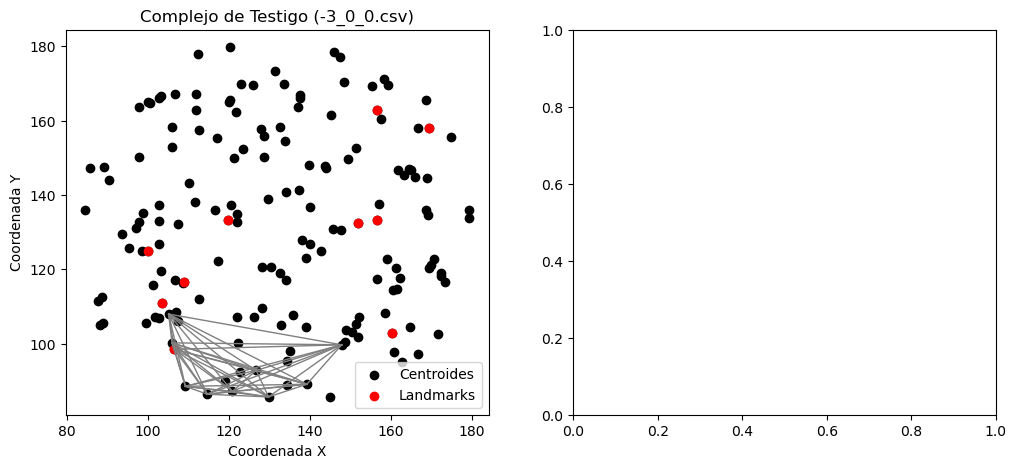

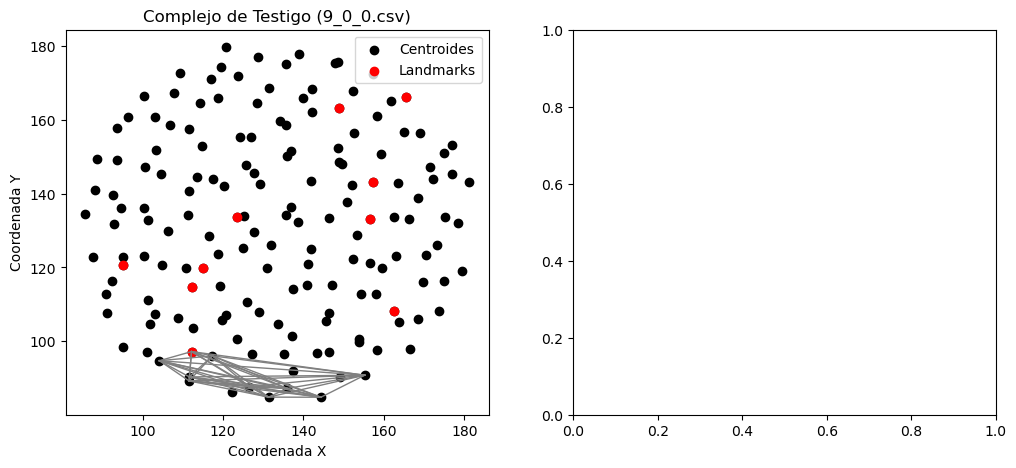

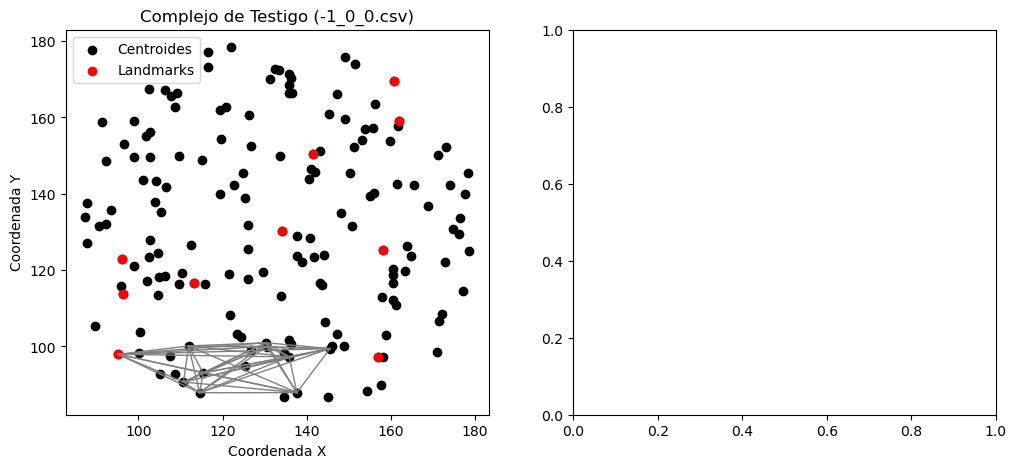

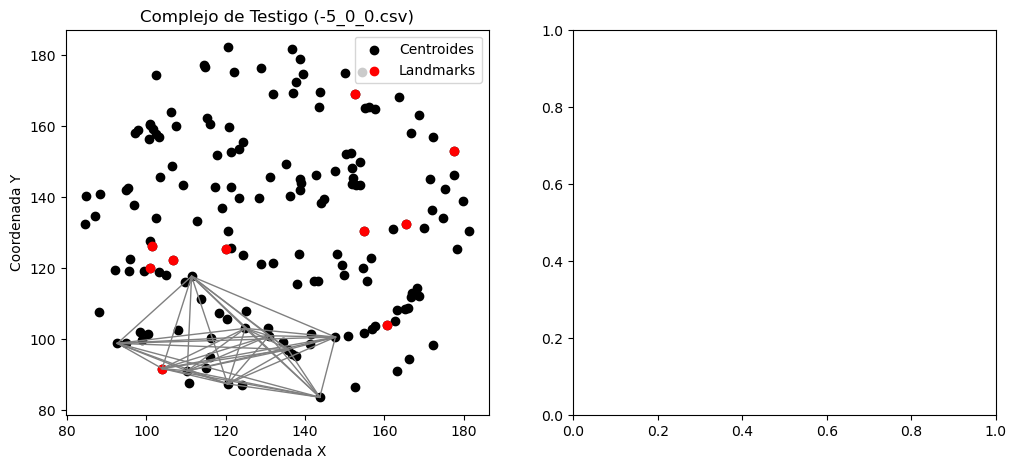

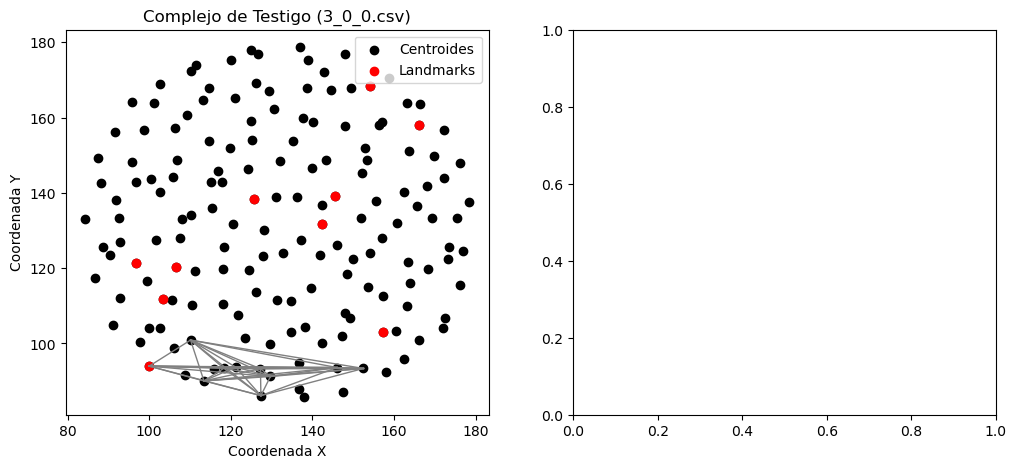

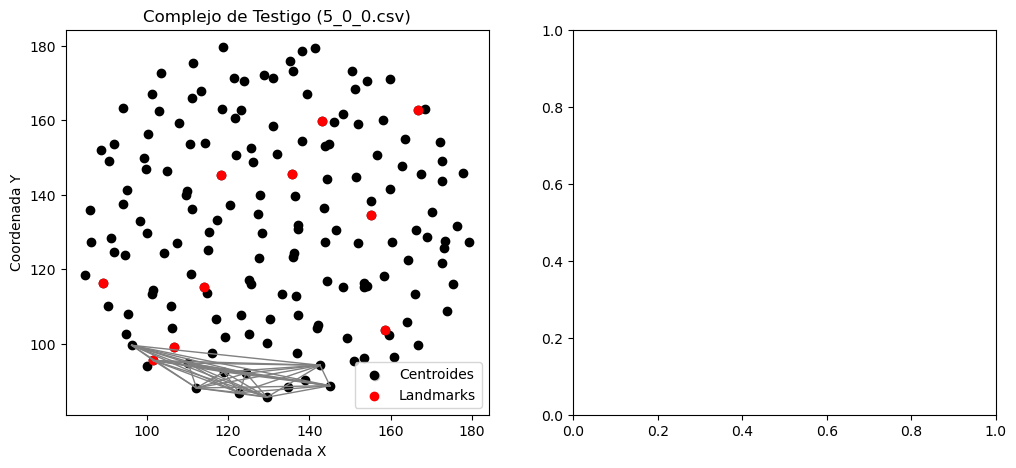

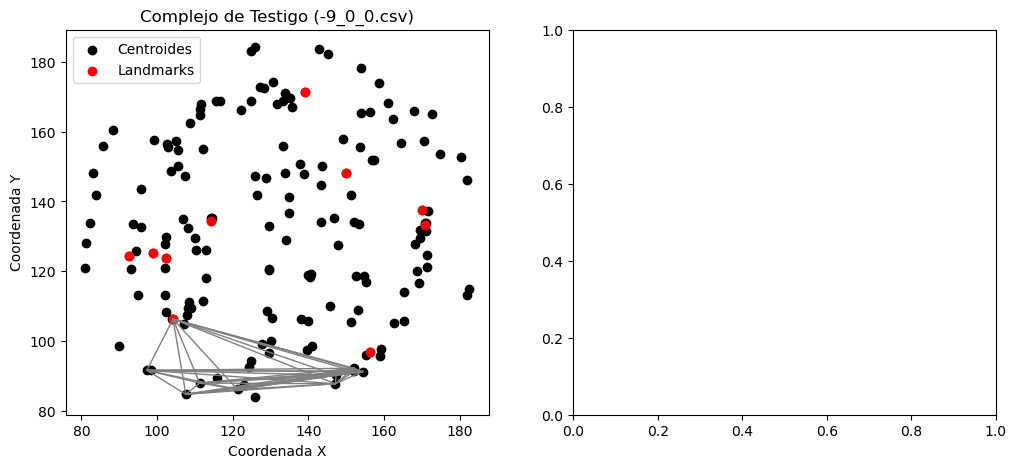

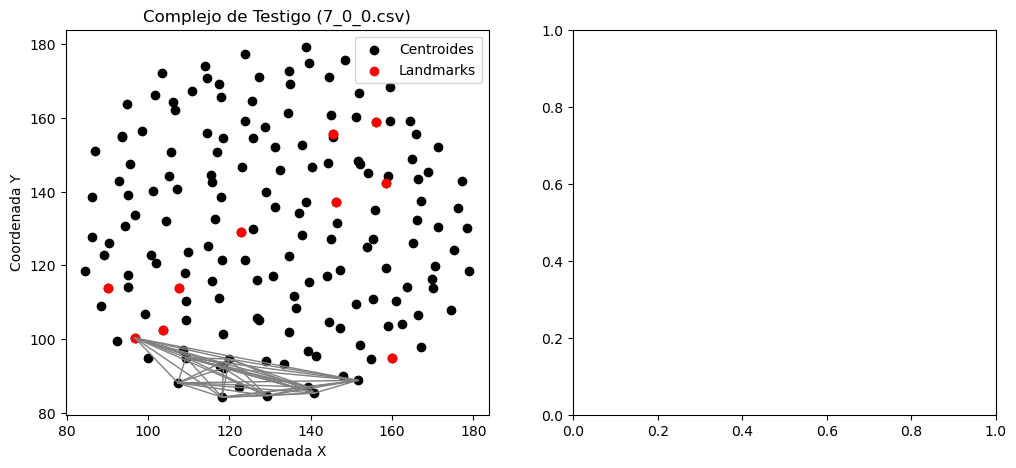

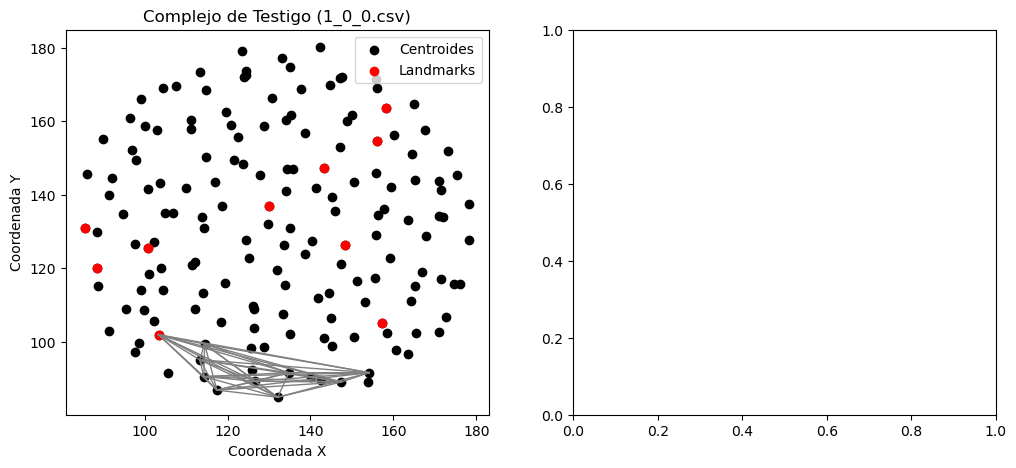

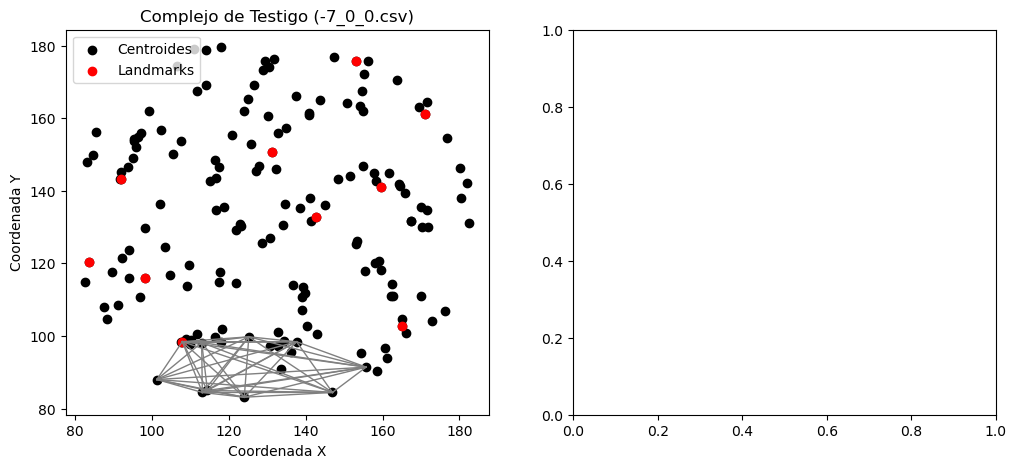

In [27]:
ruta_centroides = "/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides"
calcular_testigo_y_persistencia(ruta_centroides, num_landmarks=10, radio_max=40)



Gráfico de Testigo y diagrama de persistencia guardados para -3_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 9_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para -1_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para -5_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 3_0_0.csv en /home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo.
Gráfico de Testigo y diagrama de persistencia guardados para 5_0_0.csv en /home/jupyter-user5/multicellularity_patterns_cl

'/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides/testigo'

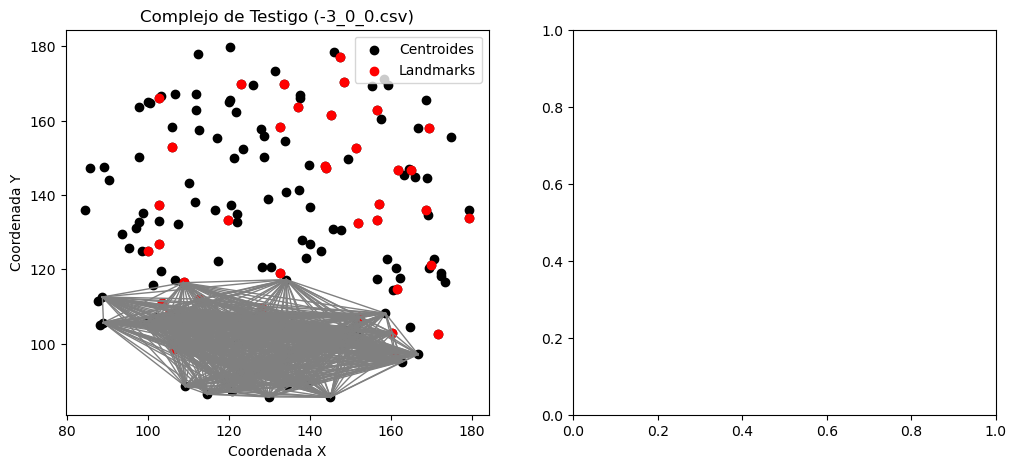

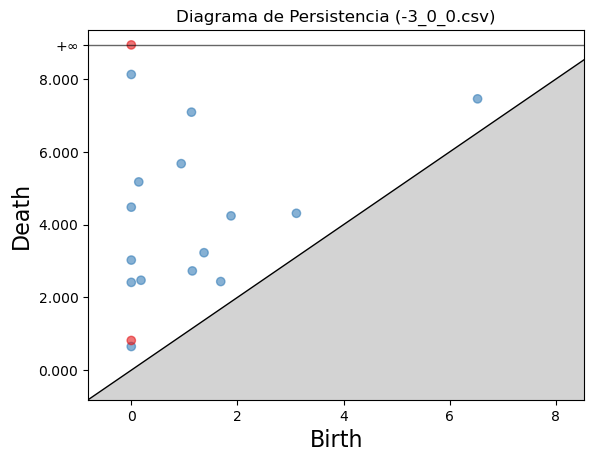

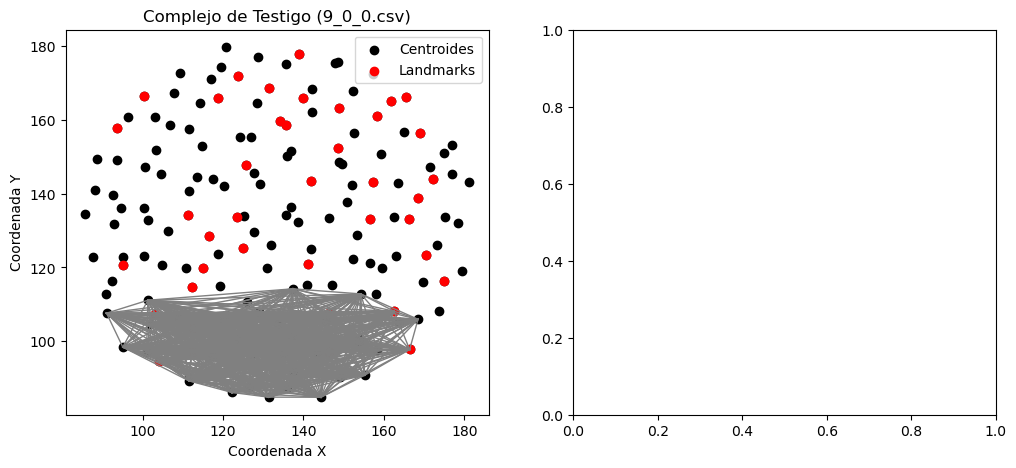

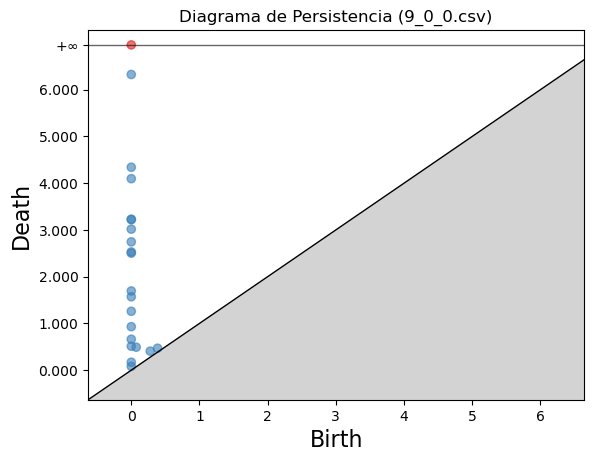

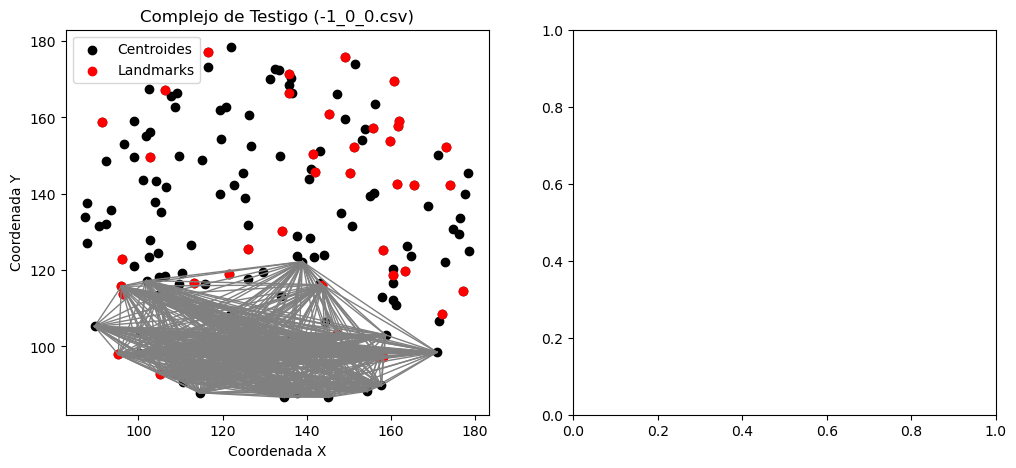

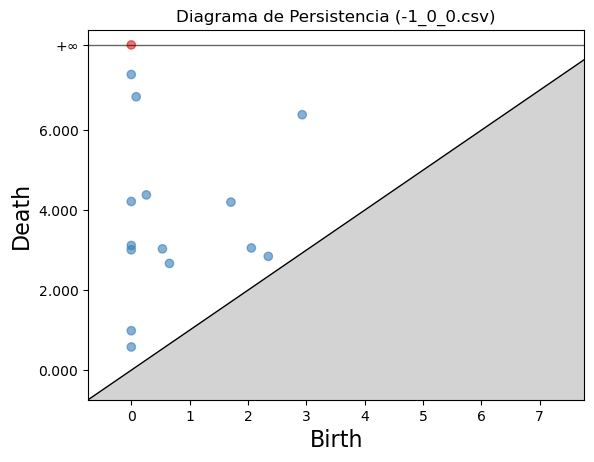

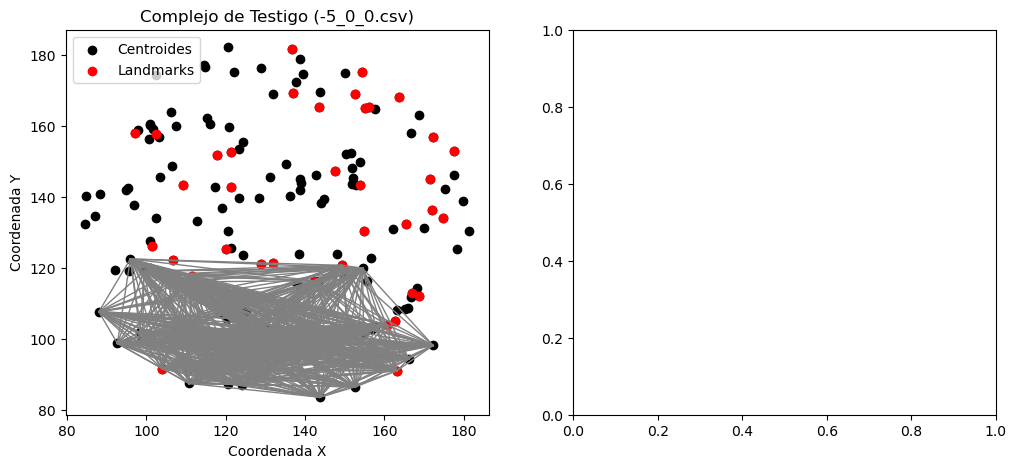

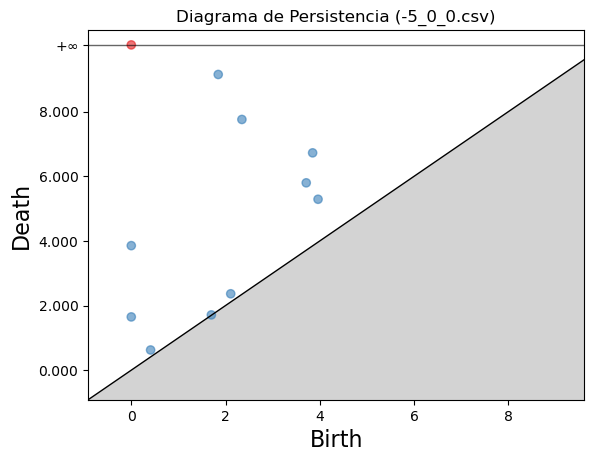

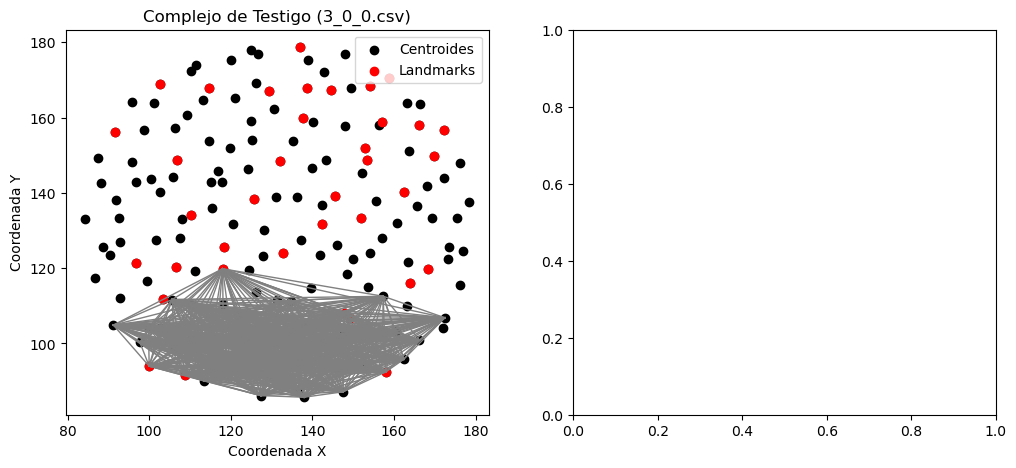

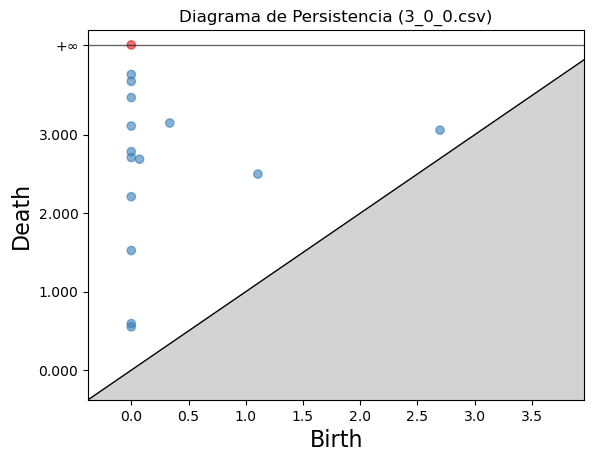

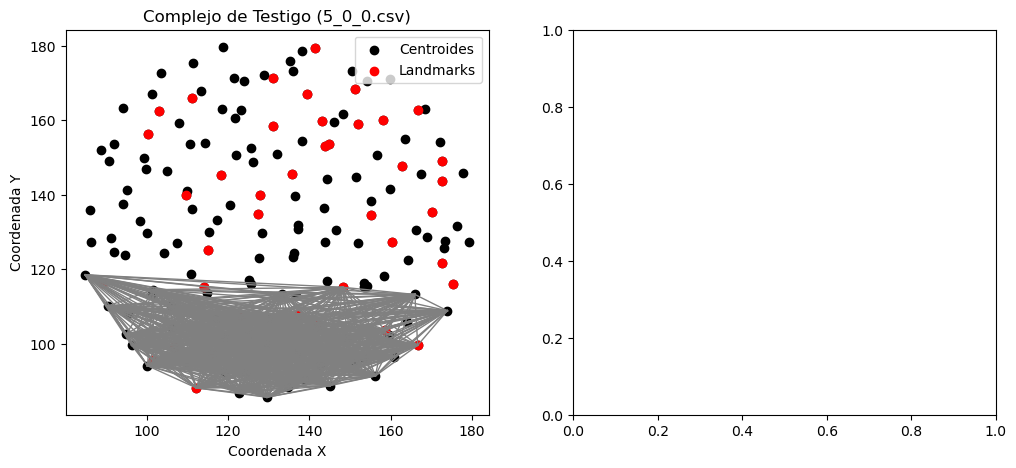

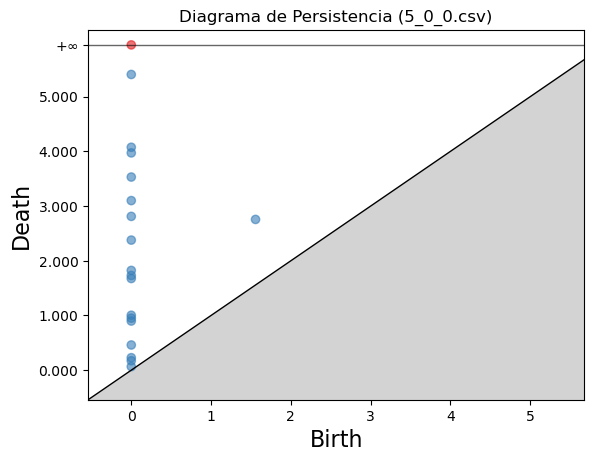

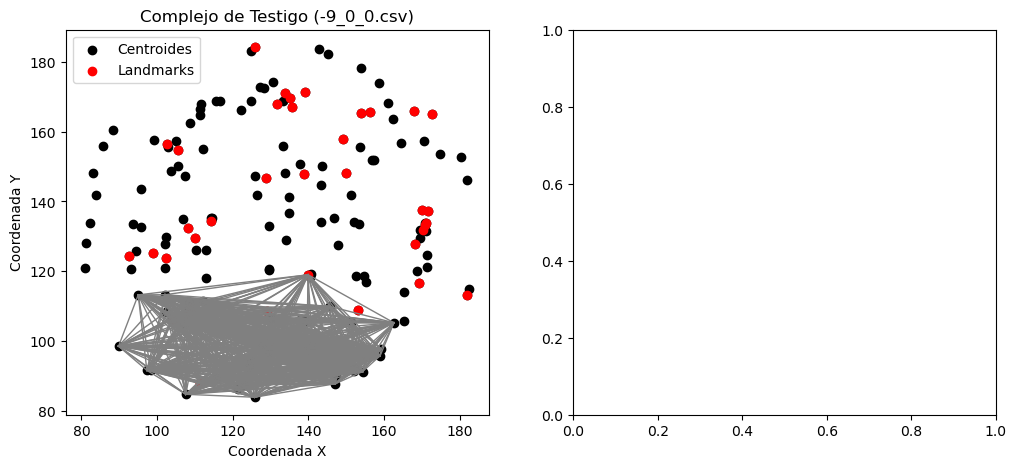

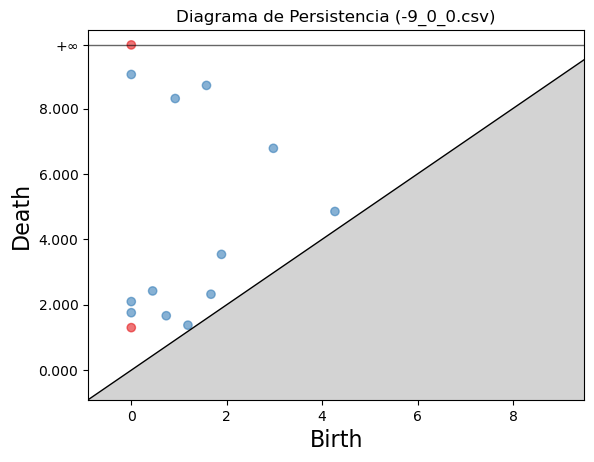

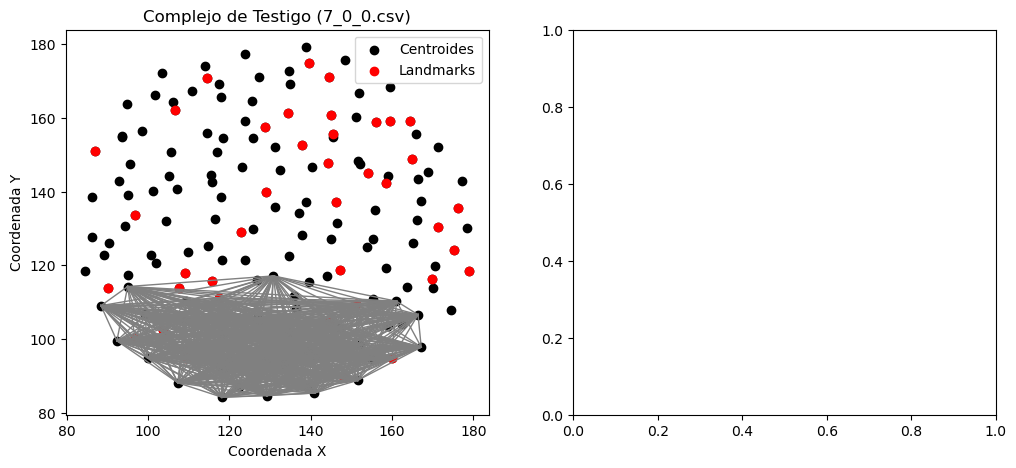

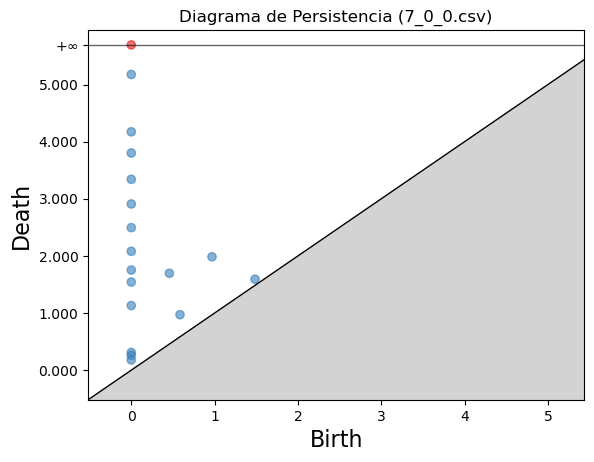

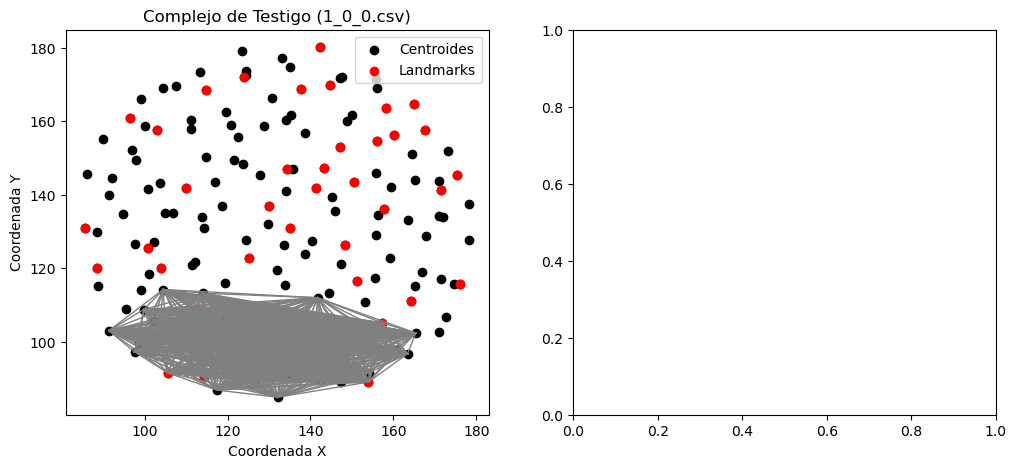

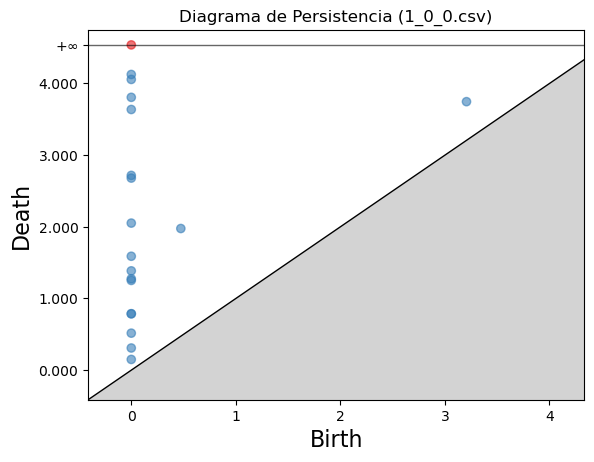

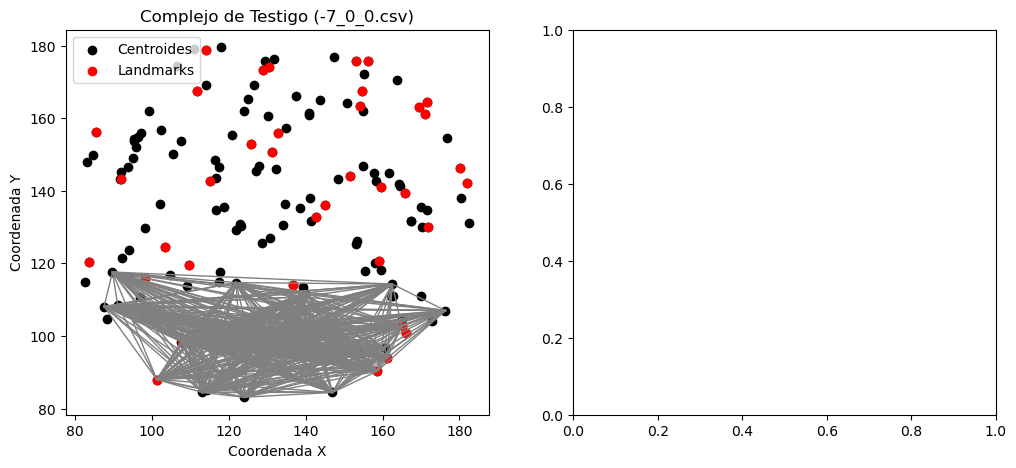

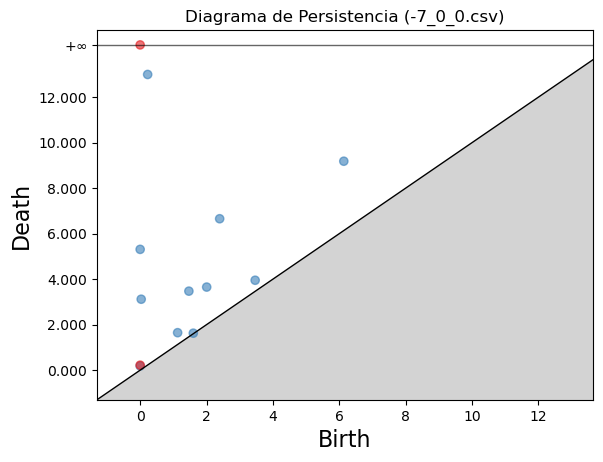

In [31]:
ruta_centroides = "/home/jupyter-user5/multicellularity_patterns_classification-/Corte1/carpeta_csv/centroides"
calcular_testigo_y_persistencia(ruta_centroides, num_landmarks=40, radio_max=40)